In [2]:
%who

Interactive namespace is empty.


In [3]:
import xarray as xr
import numpy as np
import geopandas as gpd
import datetime
import matplotlib

# getting the spatial plotting function from another directory
import sys
new_path = '/home/566/ad9701/drought_probability/final_code_AU/'
if new_path not in sys.path:
    sys.path.append(new_path)
import validation_functions as myfuncs
%run -i drought_2017to2019/dataInfo_and_functions.py

### A sample ERA5Land file

In [5]:
ds_e = xr.open_dataset('/g/data/w97/ad9701/p_prob_analysis/era5-land_daily/e/e_era5-land_oper_sfc_20200101_20200131.nc')
ds_e

<xarray.Dataset>
Dimensions:    (longitude: 421, latitude: 341, time: 31)
Coordinates:
  * longitude  (longitude) float32 112.0 112.1 112.2 112.3 ... 153.8 153.9 154.0
  * latitude   (latitude) float32 -10.0 -10.1 -10.2 -10.3 ... -43.8 -43.9 -44.0
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-01-31
Data variables:
    e          (time, latitude, longitude) float32 ...

In [6]:
lat_slice = slice(-10, -44)
lon_slice = slice(112, 154)

ds_e['e'].sel(latitude = lat_slice, longitude = lon_slice)

<xarray.DataArray 'e' (time: 31, latitude: 341, longitude: 421)>
[4450391 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 112.0 112.1 112.2 112.3 ... 153.8 153.9 154.0
  * latitude   (latitude) float32 -10.0 -10.1 -10.2 -10.3 ... -43.8 -43.9 -44.0
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-01-31
Attributes:
    units:          mm of water equivalent
    long_name:      Evaporation
    standard_name:  lwe_thickness_of_water_evaporation_amount

### Save monthly evap from GLEAM, AWRA, & ERA5Land

In [7]:
save_monthly_data

<function __main__.save_monthly_data(alldata_dict, data_name, out_dir, calc_from_daily=False, calc_fun='sum')>

In [8]:
# create a dict cotaining information 

evap_data_dict = {}
evap_data_dict['gleam'] = alldata_dict['gleam']
evap_data_dict['gleam']['file_name'] = 'E_1980-2020_GLEAM_v3.5a_MO.nc'
evap_data_dict['gleam']['varname'] = 'E'

In [20]:
out_dir = '/g/data/w97/ad9701/drought_2017to2020/ET_data/'
save_monthly_data(alldata_dict = evap_data_dict, data_name = 'gleam', out_dir = out_dir, calc_from_daily = False)

In [9]:
evap_data_dict['awra'] = alldata_dict['awra']
evap_data_dict['awra']['file_name'] = 'etot_*.nc'
evap_data_dict['awra']['varname'] = 'etot'

In [26]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="31GB",walltime='04:00:00')
client = Client(cluster)
cluster.scale(cores=2)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37503 instead
  warnings.warn(


<Client: 'tcp://10.0.128.157:38137' processes=0 threads=0, memory=0 B>

In [19]:
out_dir = '/g/data/w97/ad9701/drought_2017to2020/ET_data/'
save_monthly_data(alldata_dict = evap_data_dict, data_name = 'awra', out_dir = out_dir, calc_from_daily = True, calc_fun='sum')

Calculated monthly data


In [28]:
out_dir = '/g/data/w97/ad9701/drought_2017to2020/ET_data/'
save_monthly_data(alldata_dict = alldata_dict, data_name = 'era5land', out_dir = out_dir, calc_from_daily = True, calc_fun='sum')
cluster.scale(cores = 0)

Calculated monthly data


In [24]:
alldata_dict['era5land']

{'full_path': '/g/data/w97/ad9701/p_prob_analysis/era5-land_daily/e/',
 'file_name': 'e_era5-land_oper_sfc_*.nc',
 'varname': 'e',
 'lat_slice': slice(-10, -44, None),
 'lon_slice': slice(112, 154, None),
 'units': 'mm',
 'rename_latlon': True,
 'mon_file': ''}

In [14]:
alldata_dict.keys()

dict_keys(['mswep', 'chirps', 'agcd', 'gleam', 'awra', 'esacci'])

## Plots

In [6]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/ET_data/'
era5land_file = 'e_era5land_monthly_1950_2022.nc'
gleam_file = 'E_gleam_monthly_1980_2020.nc'
awra_file = 'etot_awra_monthly_1911_2022.nc'

ds_era5land = xr.open_dataset(data_dir + era5land_file)
ds_gleam = xr.open_dataset(data_dir + gleam_file)
ds_awra = xr.open_dataset(data_dir + awra_file)

In [5]:
ds_awra

<xarray.Dataset>
Dimensions:  (time: 1338, lat: 681, lon: 841)
Coordinates:
  * time     (time) datetime64[ns] 1911-01-31 1911-02-28 ... 2022-06-30
  * lat      (lat) float64 -10.0 -10.05 -10.1 -10.15 ... -43.9 -43.95 -44.0
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 153.8 153.9 153.9 154.0
Data variables:
    etot     (time, lat, lon) float64 ...

In [7]:
# the monthly climatology from long-term data
time_slice = slice('1981-01-01', '2020-05-31')
da_era5land_lt_monClim = ds_era5land['e'].sel(time = time_slice).groupby('time.month').mean('time')
da_gleam_lt_monClim = ds_gleam['E'].sel(time = time_slice).groupby('time.month').mean('time')
da_awra_lt_monClim = ds_awra['etot'].sel(time = time_slice).groupby('time.month').mean('time')

# the monthly anomalies during the drought period
time_slice = slice('2016-12-01', '2020-12-31')
da_era5land_monAnom = ds_era5land['e'].sel(time = time_slice).groupby('time.month') - da_era5land_lt_monClim
da_gleam_monAnom = ds_gleam['E'].sel(time = time_slice).groupby('time.month') - da_gleam_lt_monClim
da_awra_monAnom = ds_awra['etot'].sel(time = time_slice).groupby('time.month') - da_awra_lt_monClim

In [10]:
! mkdir figures/drought_2017to2020/evap

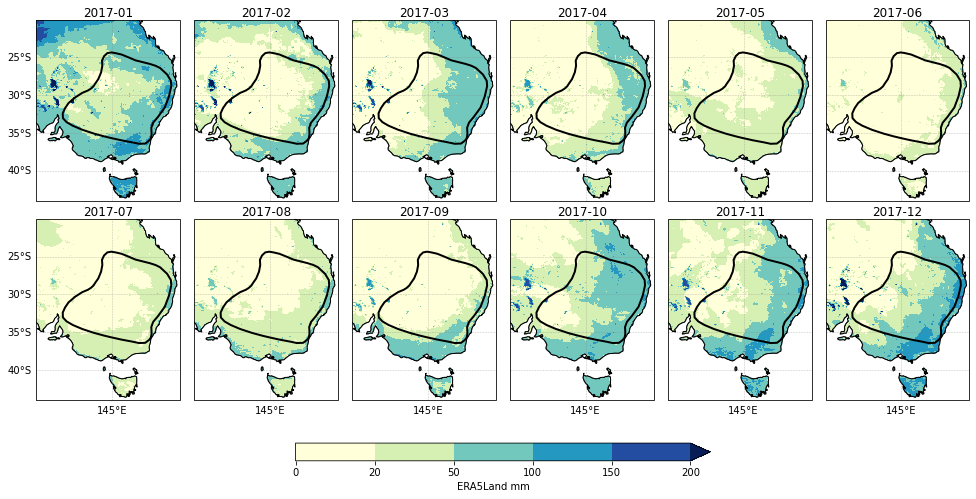

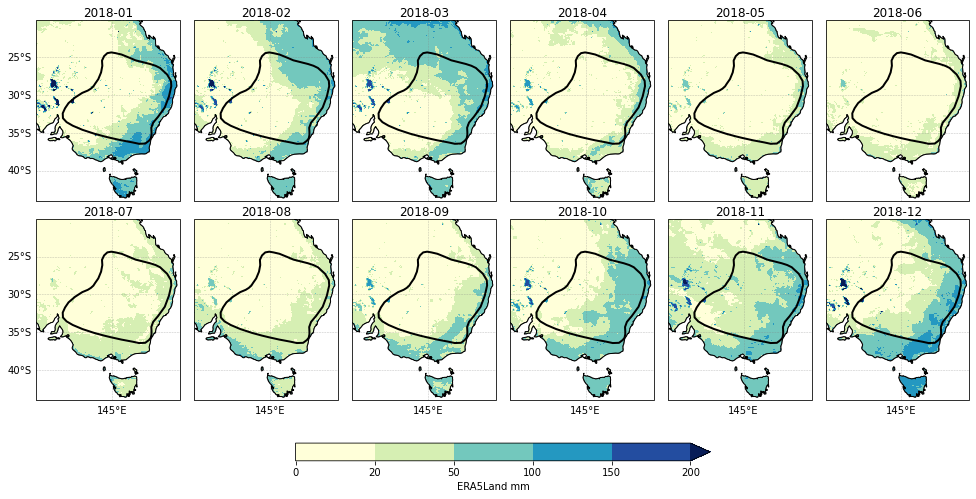

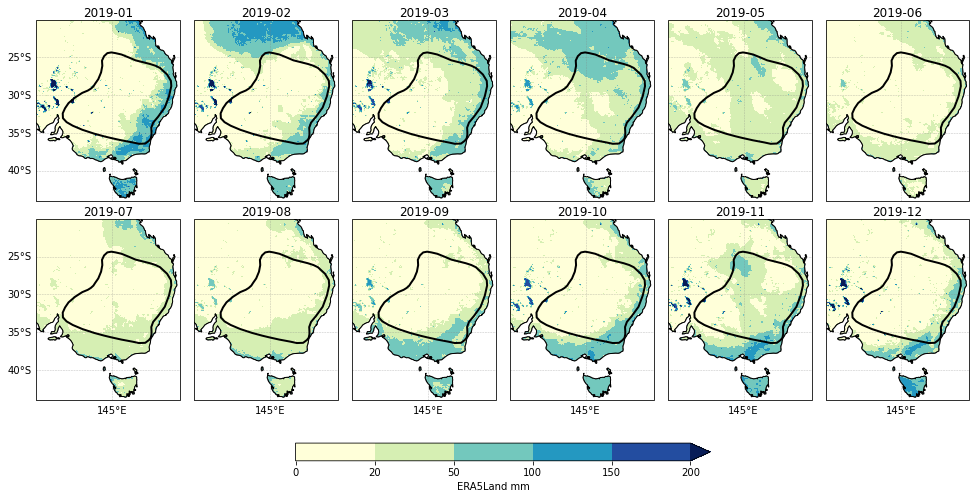

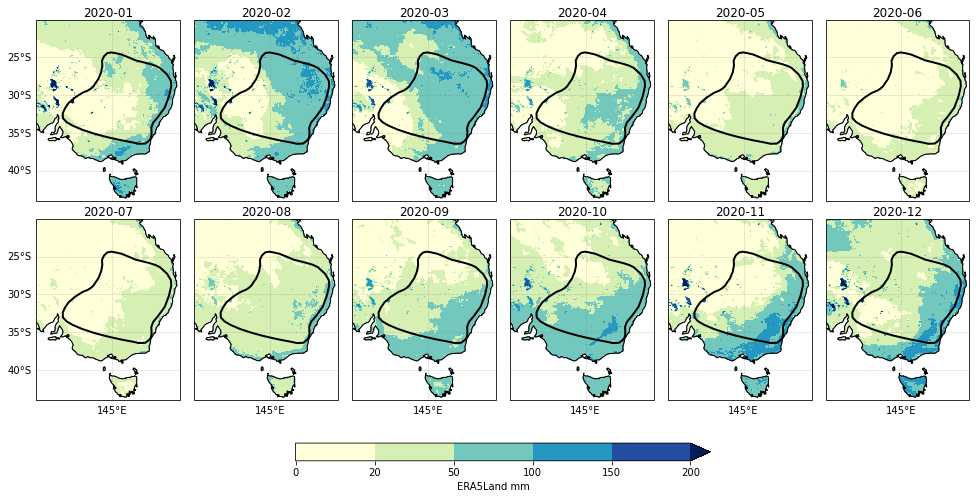

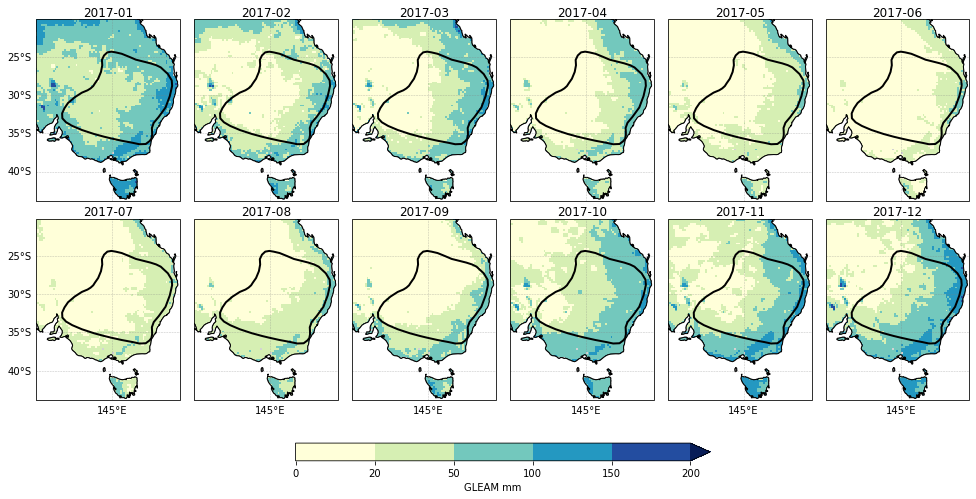

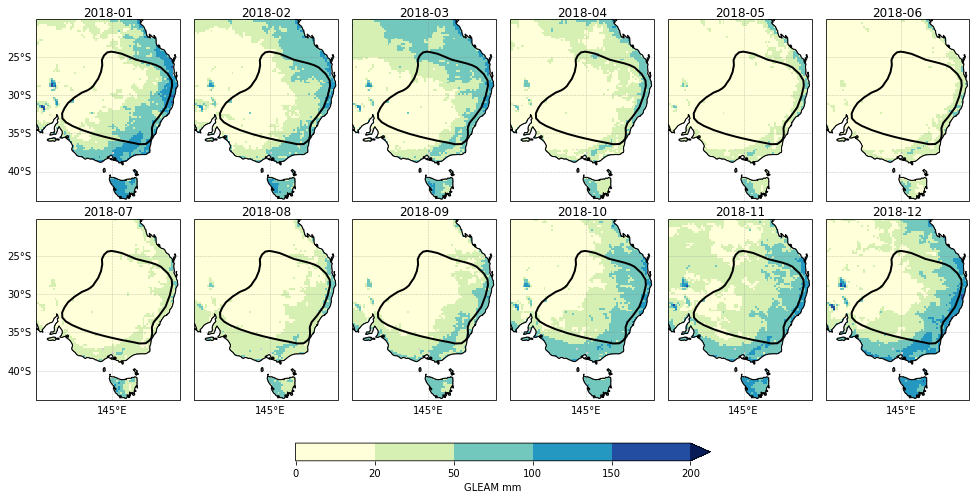

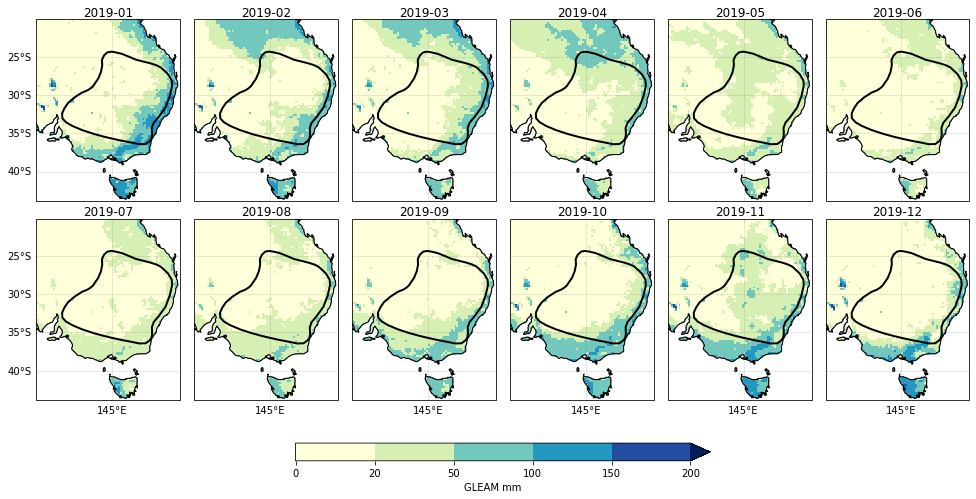

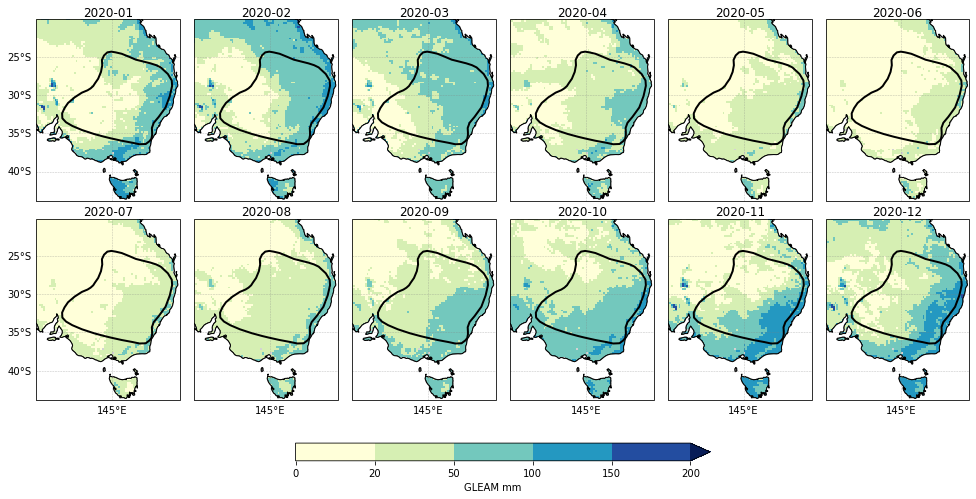

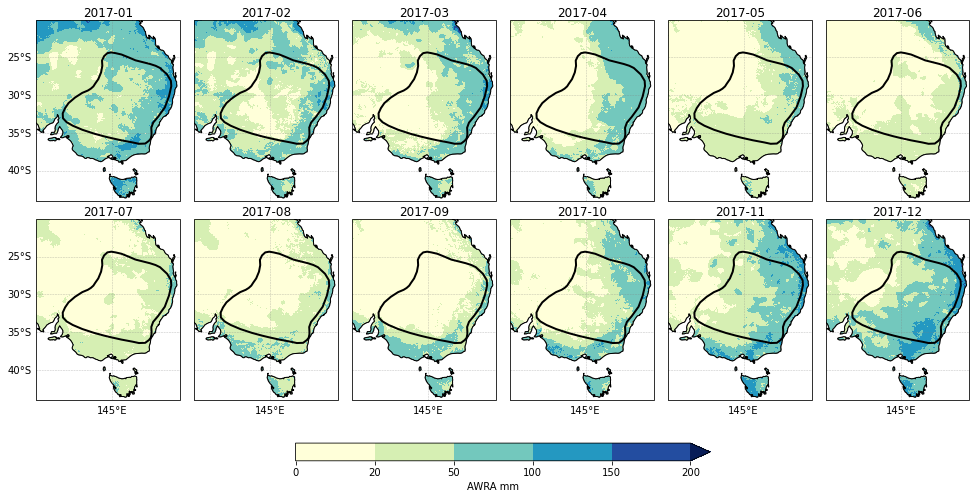

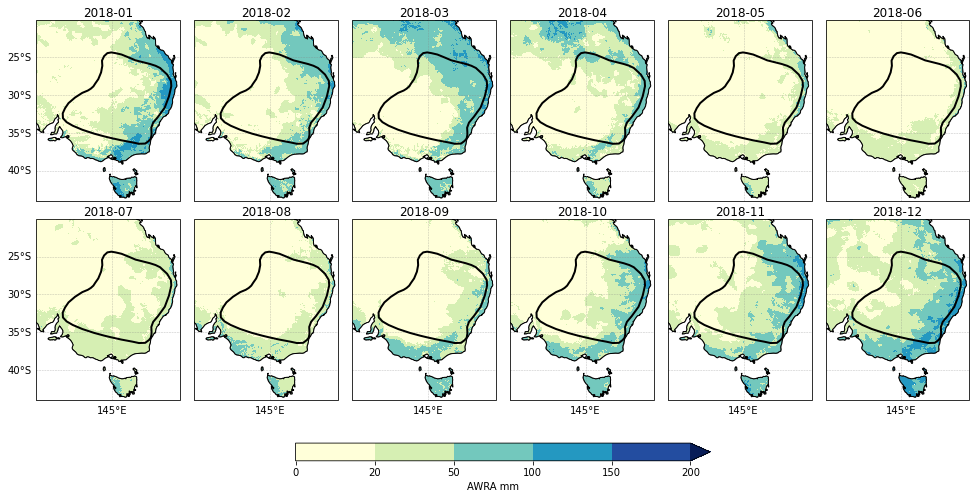

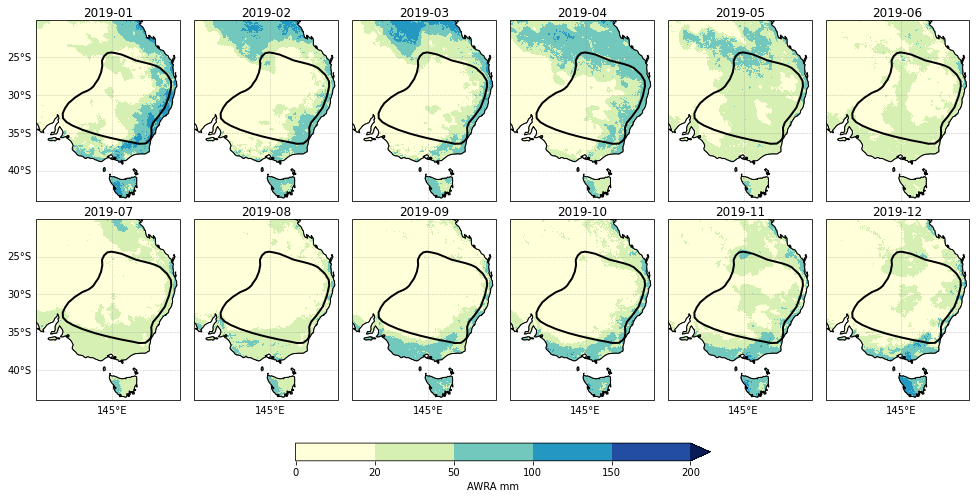

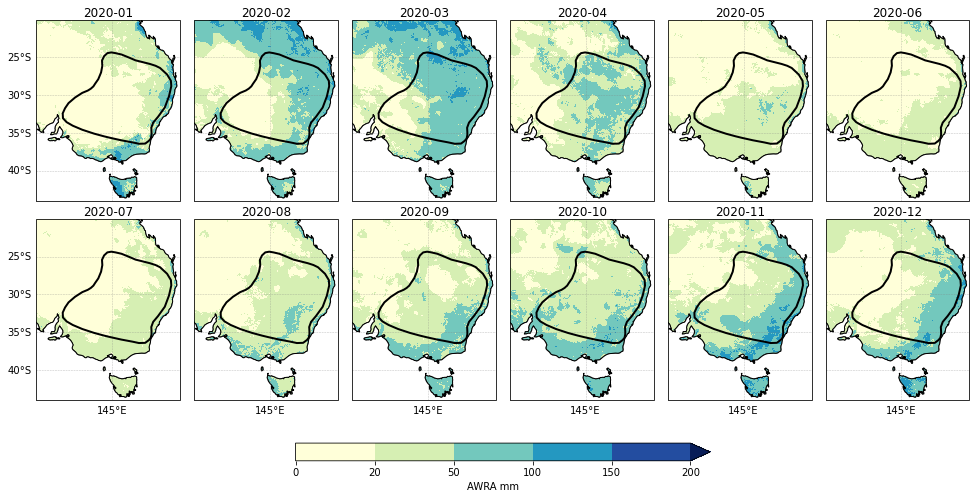

In [29]:
out_dir = 'figures/drought_2017to2020/evap/'
figname_prefix = 'evap_monMean'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("YlGnBu").copy()
current_cmap.set_bad(color='lightgrey')

# only the southeast
lat_slice_small = slice(-20, -44)
lat_slice_small_rev = slice(-44, -20)
lon_slice_small = slice(135, 154)

time_slice = slice('2017-01-01', '2020-12-31')
data_list = [ds_era5land['e'].sel(time = time_slice), ds_gleam['E'].sel(time = time_slice), ds_awra['etot'].sel(time = time_slice)]
data_names = ['ERA5Land', 'GLEAM', 'AWRA']
data_lat_slices = {'ERA5Land': lat_slice_small,
                   'GLEAM': lat_slice_small,
                   'AWRA': lat_slice_small}
    
for iDat in range(len(data_list)):  
    for year in [2017, 2018, 2019, 2020]:
        da_year = data_list[iDat].sel(time = str(year), lat=data_lat_slices[data_names[iDat]], lon=lon_slice_small)
        if data_names[iDat] == 'GLEAM':
            plot_list = [da_year.isel(time = i).transpose() for i in range(len(da_year.time.values))]
        else:
            plot_list = [da_year.isel(time = i) for i in range(len(da_year.time.values))] 

        subplot_title = [np.datetime_as_string(x.time.values, unit='M') for x in plot_list]

        levels = [0, 20, 50, 100, 150, 200]
        out_figname = data_names[iDat] + '_' + figname_prefix + '_' + str(year)
        myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, ncols = 6, nrows = 2, panel_width=2.4, panel_height=4.1, levels=levels, 
                                        subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'black',
                                        out_dir = out_dir, out_figname = out_figname, cbar_label=data_names[iDat]+' mm', cbar_extend='max')

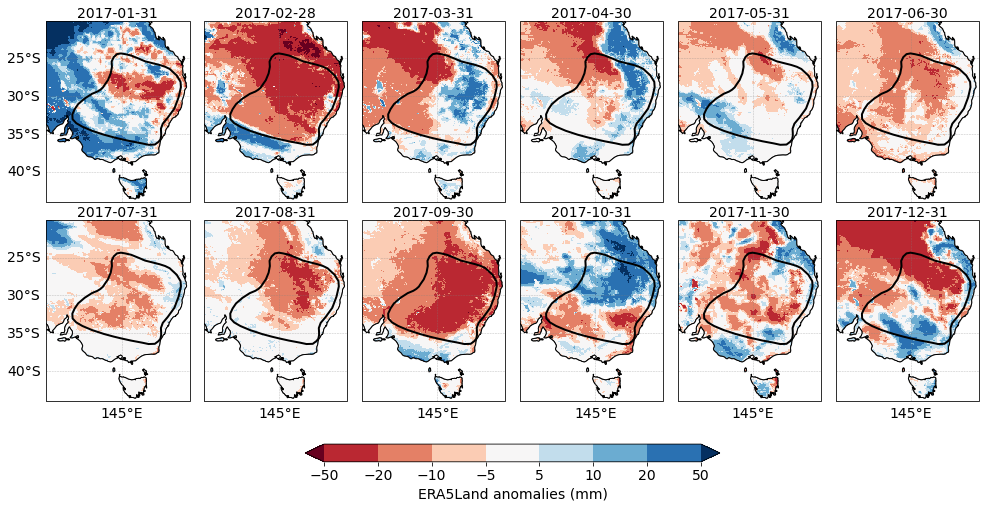

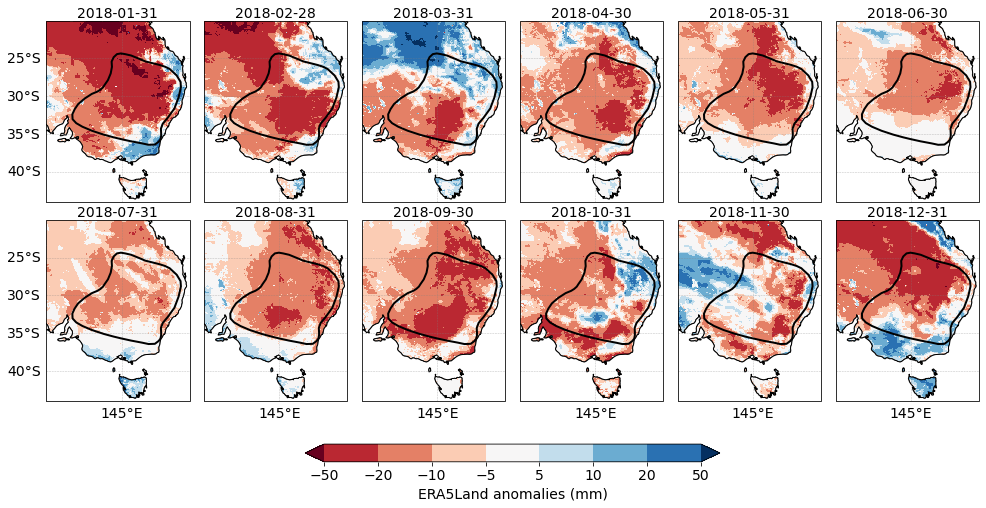

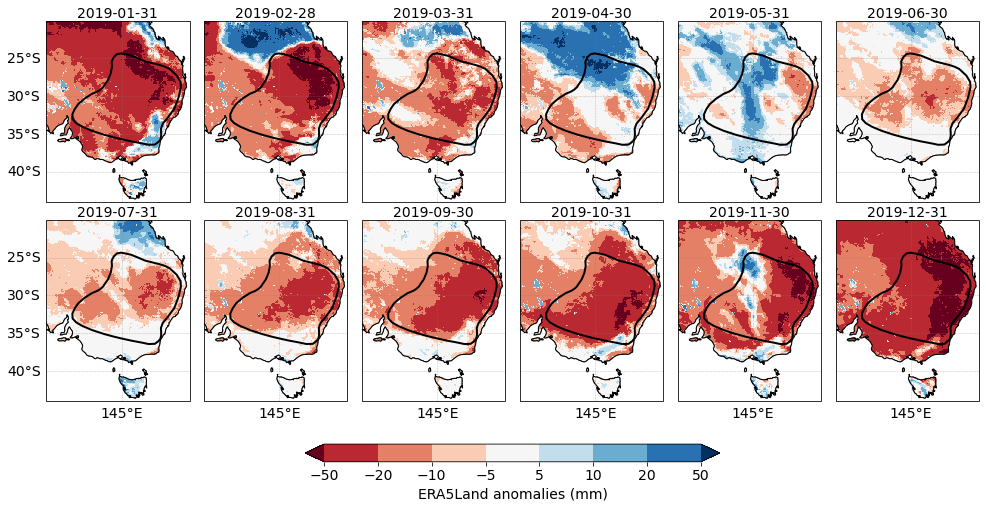

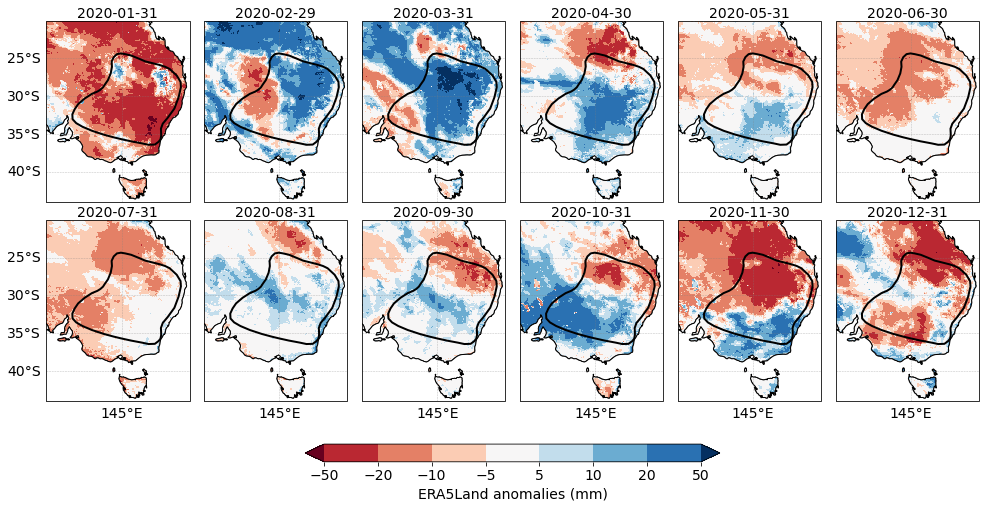

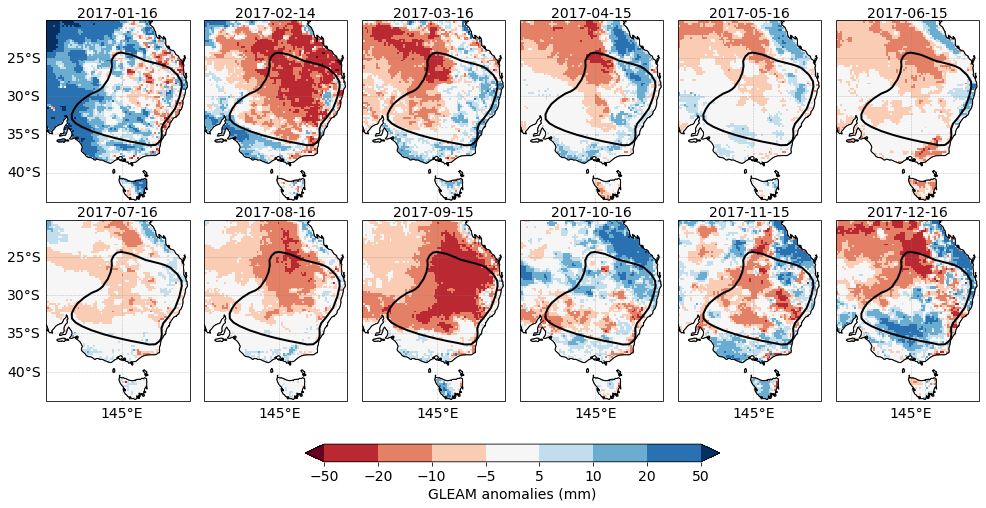

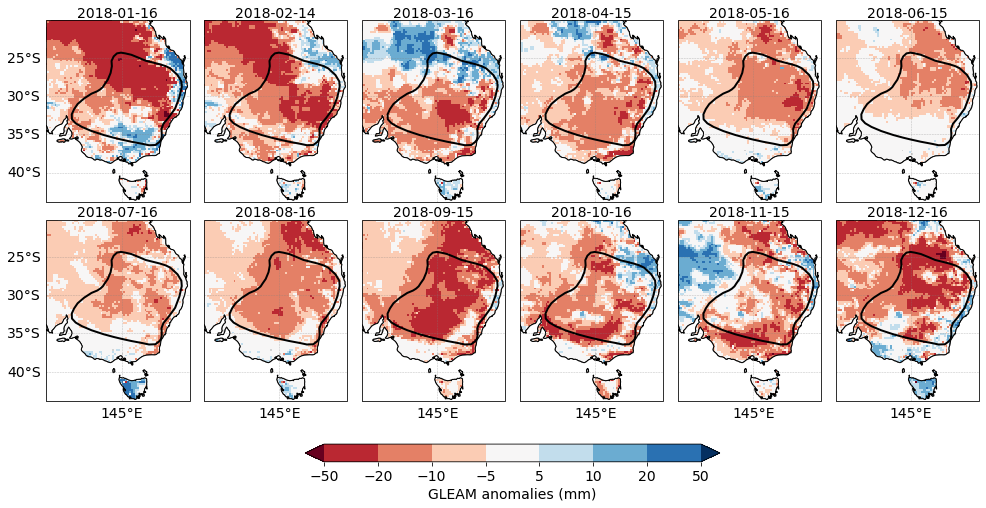

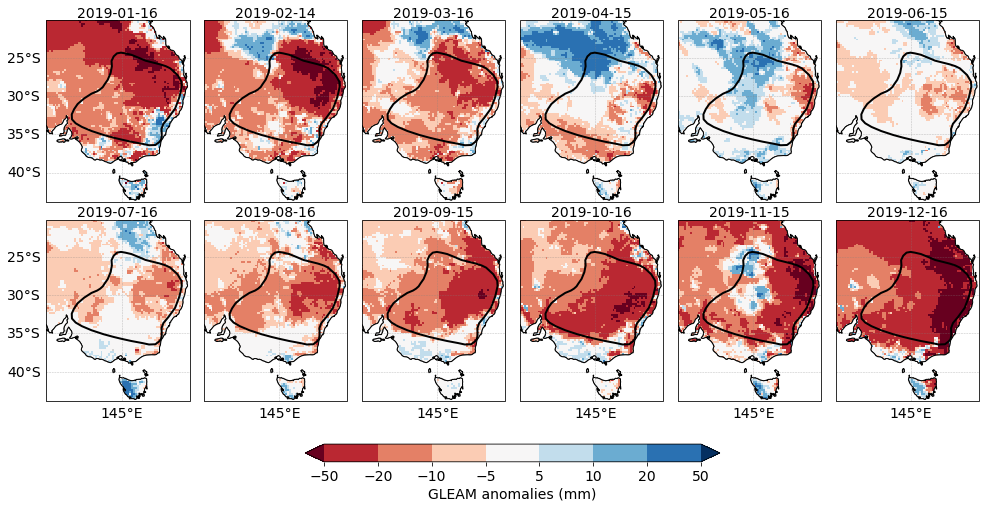

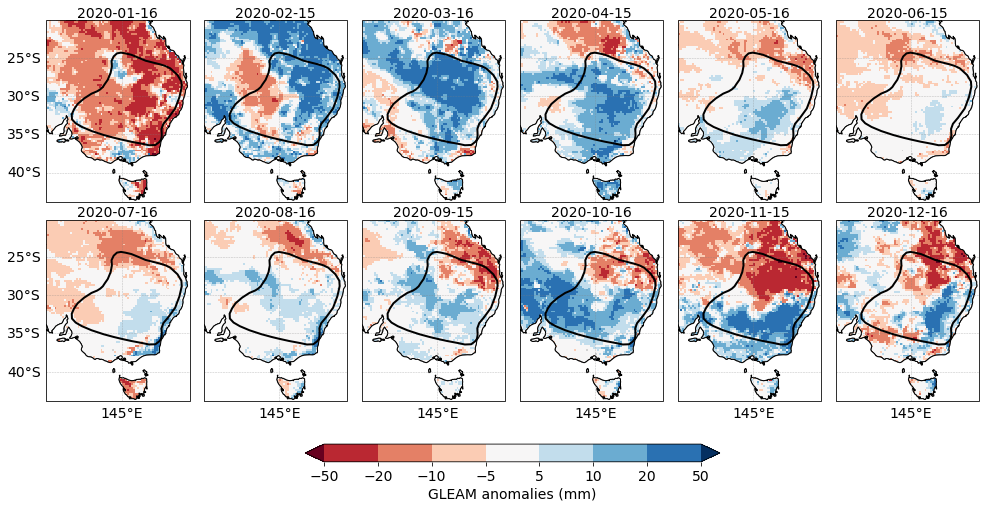

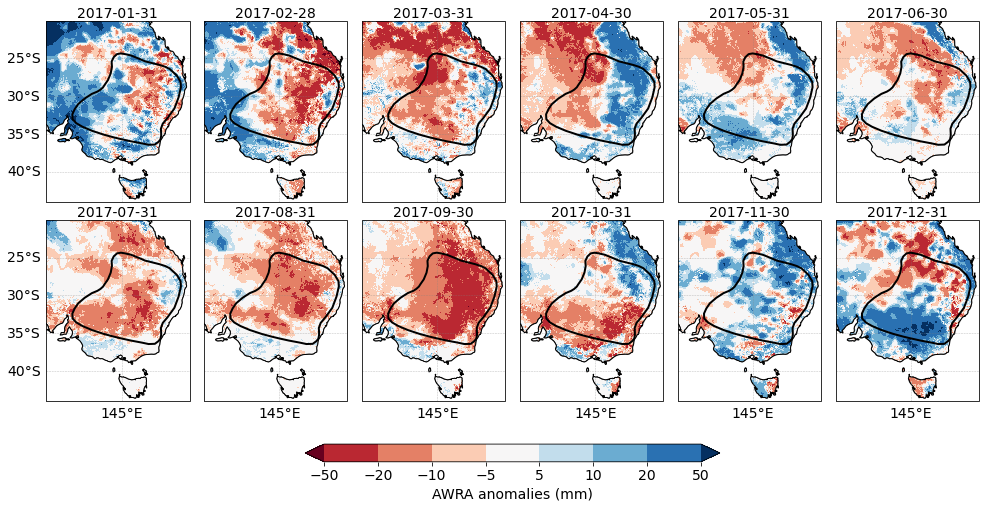

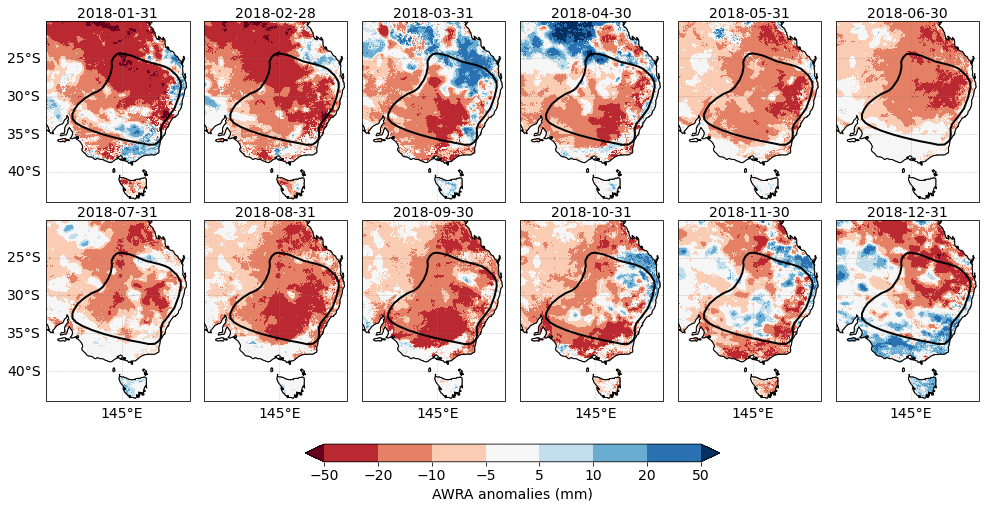

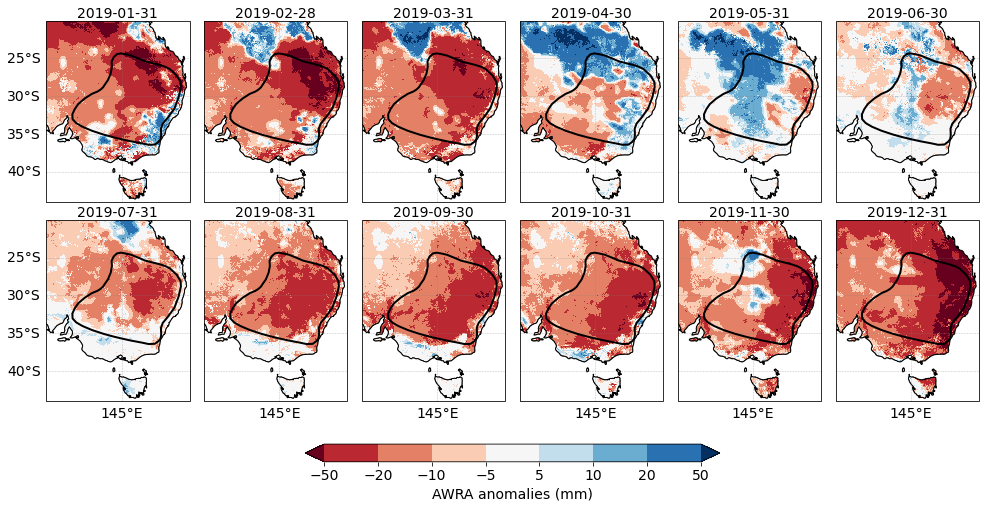

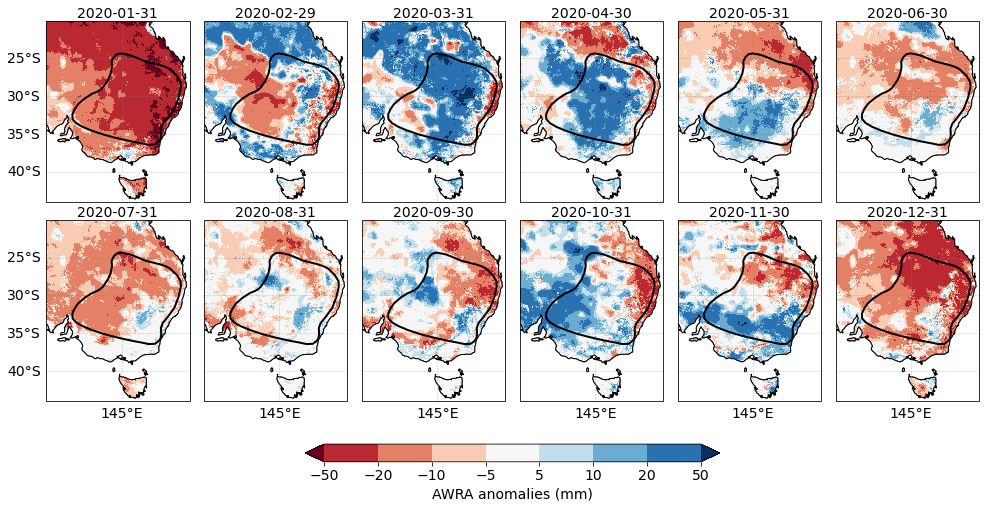

In [47]:
out_dir = 'figures/drought_2017to2020/evap/'
figname_prefix = 'evap_monAnom'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("RdBu").copy()
current_cmap.set_bad(color='lightgrey')

# only the southeast
lat_slice_small = slice(-20, -44)
lat_slice_small_rev = slice(-44, -20)
lon_slice_small = slice(135, 154)

data_list = [da_era5land_monAnom, da_gleam_monAnom, da_awra_monAnom]
data_names = ['ERA5Land', 'GLEAM', 'AWRA']
data_lat_slices = {'ERA5Land': lat_slice_small,
                   'GLEAM': lat_slice_small,
                   'AWRA': lat_slice_small}
    
for iDat in range(len(data_list)):  
    for year in [2017, 2018, 2019, 2020]:
        da_year = data_list[iDat].sel(time = str(year), lat=data_lat_slices[data_names[iDat]], lon=lon_slice_small)
        if data_names[iDat] == 'GLEAM':
            plot_list = [da_year.isel(time = i).transpose() for i in range(len(da_year.time.values))]
        else:
            plot_list = [da_year.isel(time = i) for i in range(len(da_year.time.values))] 

        subplot_title = [np.datetime_as_string(x.time.values, unit='D') for x in plot_list]

        levels = [-50, -20, -10, -5, 5, 10, 20, 50]
        out_figname = data_names[iDat] + '_' + figname_prefix + '_' + str(year)
        myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, ncols = 6, nrows = 2, panel_width=2.4, panel_height=4.1, levels=levels, 
                                        subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'black',
                                        out_dir = out_dir, out_figname = out_figname, cbar_label=data_names[iDat]+' anomalies (mm)') #, cbar_extend='max')

### Area averages 
Quatifying deficit in evaporation

In [8]:
# get a region mask using the drought focus region shapefile
import regionmask

# read in the focus region shapefile
drought_focusReg = gpd.read_file('/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp')

# data_list = [ds_era5land['e'].isel(time = 0), ds_gleam['E'].isel(time = 0), ds_awra['etot'].isel(time = 0)]
data_names = ['ERA5Land', 'GLEAM', 'AWRA']

# for iDat in range(len(data_list)):
#     # create a mask of the polygon for the lat-long values in ds. The mask would contain '0' inside the region; nan otherwise
#     da_mask_zeros = regionmask.mask_geopandas(geodataframe = drought_focusReg, lon_or_obj = data_list[iDat].lon.values, lat = data_list[iDat].lat.values)
#     # setting the points inside the region to 1
#     da_mask = xr.where(da_mask_zeros == 0, 1, np.nan)

#     # save the mask into a netcdf file
#     out_file = '/g/data/w97/ad9701/drought_2017to2020/' + data_names[iDat] + '_mask_drought_focusArea.nc'
#     da_mask.to_netcdf(out_file)

# read mask from saved files
mask_file = '/g/data/w97/ad9701/drought_2017to2020/ERA5Land_mask_drought_focusArea.nc'
ds_era5land_mask = xr.open_dataset(mask_file)
da_era5land_mask = ds_era5land_mask['mask']

mask_file = '/g/data/w97/ad9701/drought_2017to2020/GLEAM_mask_drought_focusArea.nc'
ds_gleam_mask = xr.open_dataset(mask_file)
da_gleam_mask = ds_gleam_mask['mask']

mask_file = '/g/data/w97/ad9701/drought_2017to2020/AWRA_mask_drought_focusArea.nc'
ds_awra_mask = xr.open_dataset(mask_file)
da_awra_mask = ds_awra_mask['mask']

In [9]:
da_era5land_monAnom_masked = da_era5land_monAnom*da_era5land_mask
da_era5land_monAnom_regAvg = myfuncs.calc_areaAvg(da_era5land_monAnom_masked)

da_gleam_monAnom_masked = da_gleam_monAnom*da_gleam_mask
da_gleam_monAnom_regAvg = myfuncs.calc_areaAvg(da_gleam_monAnom_masked)

da_awra_monAnom_masked = da_awra_monAnom*da_awra_mask
da_awra_monAnom_regAvg = myfuncs.calc_areaAvg(da_awra_monAnom_masked)

In [10]:
import pandas as pd

da_time_bymon = np.array(pd.to_datetime(da_era5land_monAnom_regAvg.time).to_period('M').to_timestamp().floor('D'))
da_era5land_monAnom_regAvg = da_era5land_monAnom_regAvg.assign_coords({'time': da_time_bymon})

da_time_bymon = np.array(pd.to_datetime(da_gleam_monAnom_regAvg.time).to_period('M').to_timestamp().floor('D'))
da_gleam_monAnom_regAvg = da_gleam_monAnom_regAvg.assign_coords({'time': da_time_bymon})

da_time_bymon = np.array(pd.to_datetime(da_awra_monAnom_regAvg.time).to_period('M').to_timestamp().floor('D'))
da_awra_monAnom_regAvg = da_awra_monAnom_regAvg.assign_coords({'time': da_time_bymon})

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

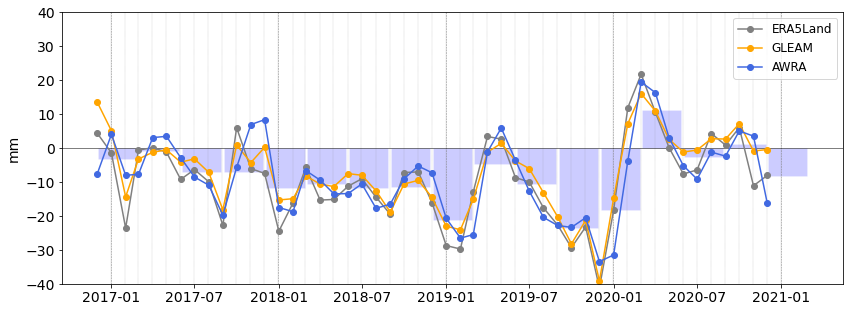

In [12]:
import pandas as pd

out_dir = 'figures/drought_2017to2020/evap/'
col_sel = ['gray', 'orange', 'royalblue']
data_list = [da_era5land_monAnom_regAvg, da_gleam_monAnom_regAvg, da_awra_monAnom_regAvg]
data_names = ['ERA5Land', 'GLEAM', 'AWRA']

data_list = [da_era5land_monAnom_regAvg, da_gleam_monAnom_regAvg, da_awra_monAnom_regAvg]
da_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

xx = da_allDatamean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
array_time = [x.astype('datetime64[D]') for x in xx]
array_val = da_allDatamean.resample(time="QS-DEC").mean().values
plt.bar(array_time, array_val, width=85, edgecolor='white', color='blue', alpha=0.2)

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
for da, color, label in zip(data_list, col_sel, data_names):       
    plt.plot(da.time.values, da.values, marker='o', color=color, label=label)
             #ecolor='lightsteelblue', elinewidth=3, capsize=0)
#da_sm_monAnom_regAvg.plot.line(color="royalblue", marker="o", linewidth=1)
plt.xlabel('')
plt.ylabel('mm')
plt.ylim((-40, 40))
plt.legend(loc=0)

fig.savefig(out_dir + 'areaAvg_evap_anom_from_monClim_inmm.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'areaAvg_evap_anom_from_monClim_inmm.pdf', bbox_inches='tight', format='pdf')

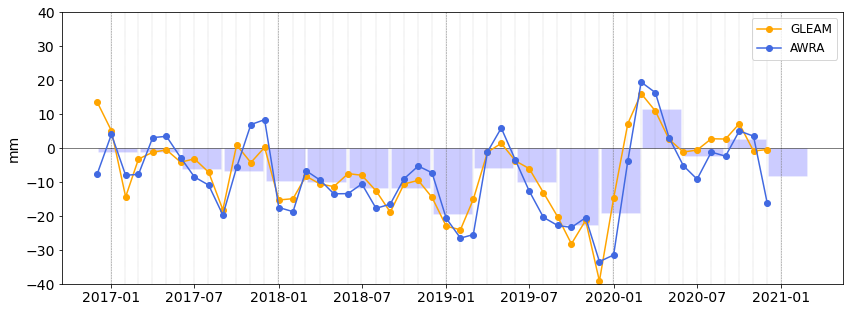

In [13]:
import pandas as pd

out_dir = 'figures/drought_2017to2020/evap/'
col_sel = ['orange', 'royalblue']
data_list = [da_gleam_monAnom_regAvg, da_awra_monAnom_regAvg]
data_names = ['GLEAM', 'AWRA']

data_list = [da_gleam_monAnom_regAvg, da_awra_monAnom_regAvg]
da_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

xx = da_allDatamean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
array_time = [x.astype('datetime64[D]') for x in xx]
array_val = da_allDatamean.resample(time="QS-DEC").mean().values
plt.bar(array_time, array_val, width=85, edgecolor='white', color='blue', alpha=0.2)

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
for da, color, label in zip(data_list, col_sel, data_names):       
    plt.plot(da.time.values, da.values, marker='o', color=color, label=label)
             #ecolor='lightsteelblue', elinewidth=3, capsize=0)
#da_sm_monAnom_regAvg.plot.line(color="royalblue", marker="o", linewidth=1)
plt.xlabel('')
plt.ylabel('mm')
plt.ylim((-40, 40))
plt.legend(loc=0)

fig.savefig(out_dir + 'areaAvg_evap_anom_from_monClim_inmm_exEraLand.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'areaAvg_evap_anom_from_monClim_inmm_exEraLand.pdf', bbox_inches='tight', format='pdf')

In [14]:
da_era5land_lt_monClim_masked = da_era5land_lt_monClim*da_era5land_mask
da_era5land_lt_monClim_regAvg = myfuncs.calc_areaAvg(da_era5land_lt_monClim_masked)

da_gleam_lt_monClim_masked = da_gleam_lt_monClim*da_gleam_mask
da_gleam_lt_monClim_regAvg = myfuncs.calc_areaAvg(da_gleam_lt_monClim_masked)

da_awra_lt_monClim_masked = da_awra_lt_monClim*da_awra_mask
da_awra_lt_monClim_regAvg = myfuncs.calc_areaAvg(da_awra_lt_monClim_masked)

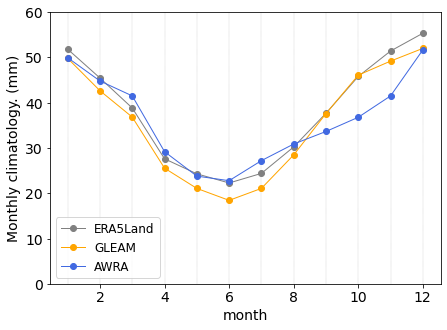

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(7,5)) #width, height

data_list = [da_era5land_lt_monClim_regAvg, da_gleam_lt_monClim_regAvg, da_awra_lt_monClim_regAvg]
col_sel = ['gray', 'orange', 'royalblue']
data_names = ['ERA5Land', 'GLEAM', 'AWRA']

for xline in range(1, 13):
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)

for da, color, label in zip(data_list, col_sel, data_names):  
    plt.plot(da.month.values, da.values, color=color, marker="o", linewidth=1, label=label)
plt.xlabel('month')
plt.ylabel('Monthly climatology. (mm)')
plt.ylim((0, 60))
plt.legend(loc=0)

fig.savefig(out_dir + 'evap_monClim.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'evap_monClim.pdf', bbox_inches='tight', format='pdf')

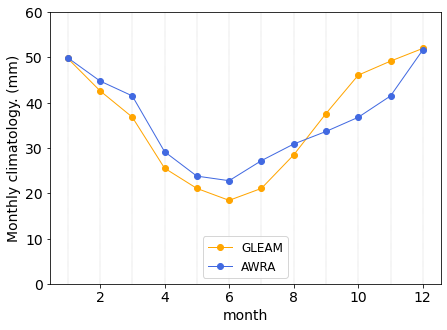

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(7,5)) #width, height

data_list = [da_gleam_lt_monClim_regAvg, da_awra_lt_monClim_regAvg]
col_sel = ['orange', 'royalblue']
data_names = ['GLEAM', 'AWRA']

for xline in range(1, 13):
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)

for da, color, label in zip(data_list, col_sel, data_names):  
    plt.plot(da.month.values, da.values, color=color, marker="o", linewidth=1, label=label)
plt.xlabel('month')
plt.ylabel('Monthly climatology. (mm)')
plt.ylim((0, 60))
plt.legend(loc=0)

fig.savefig(out_dir + 'evap_monClim_exEraLand.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'evap_monClim_exEraLand.pdf', bbox_inches='tight', format='pdf')

### Yearly plot

In [8]:
da_era5land_masked = ds_era5land['e']*da_era5land_mask
da_era5land_regAvg = myfuncs.calc_areaAvg(da_era5land_masked)

da_gleam_masked = ds_gleam['E']*da_gleam_mask
da_gleam_regAvg = myfuncs.calc_areaAvg(da_gleam_masked)

da_awra_masked = ds_awra['etot']*da_awra_mask
da_awra_regAvg = myfuncs.calc_areaAvg(da_awra_masked)

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

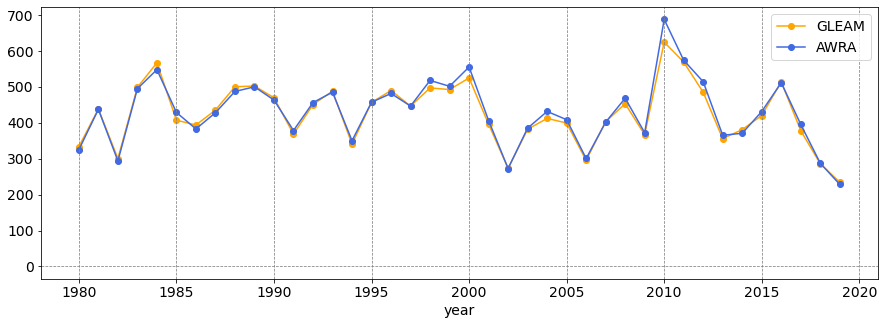

In [19]:
col_sel = ['gray', 'orange', 'royalblue']

#da_era5land_regAvg.groupby('time.year').sum().sel(year = slice(1980, 2019)).plot(color = col_sel[0], marker="o", label='ERA5Land', size=5, aspect=3)
da_gleam_regAvg.groupby('time.year').sum().sel(year = slice(1980, 2019)).plot(color = col_sel[1], marker="o", label='GLEAM', size=5, aspect=3)
da_awra_regAvg.groupby('time.year').sum().sel(year = slice(1980, 2019)).plot(color = col_sel[2], marker="o", label='AWRA')
plt.axhline(0, color = 'gray', linestyle='--', linewidth=0.75)
for xline in [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.75)
plt.legend(loc = 'upper right')

out_dir = 'figures/drought_2017to2020/evap/'
plt.savefig(out_dir + 'evap_yearly_1980_2019.png', bbox_inches='tight')

In [13]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/precip_data/drought_focusRegavg/'
agcd_file = 'agcd_monthly_1900_2020.nc'
ds_agcd = xr.open_dataset(data_dir + agcd_file)
chirps_file = 'chirps_monthly_1981_2021.nc'
ds_chirps = xr.open_dataset(data_dir + chirps_file)
mswep_file = 'precipitation_mswep_monthly_1979_2021.nc'
ds_mswep = xr.open_dataset(data_dir + mswep_file)

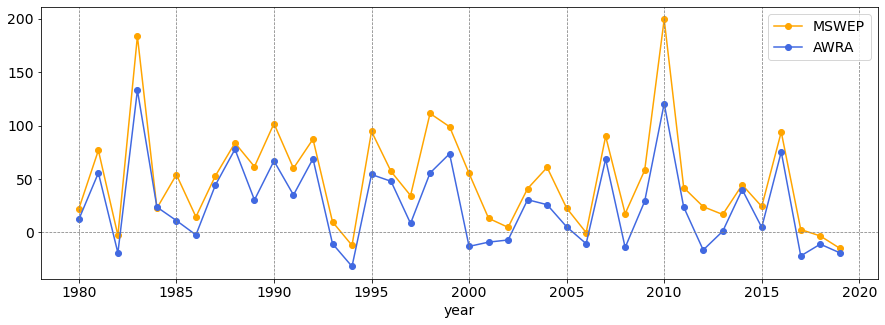

In [15]:
col_sel = ['gray', 'orange', 'royalblue']

((ds_mswep['precipitation'].groupby('time.year').sum())-(da_gleam_regAvg.groupby('time.year').sum())).sel(year = slice(1980, 2019)).plot(color = col_sel[1], marker="o", label='MSWEP', size=5, aspect=3)
((ds_agcd['precip'].groupby('time.year').sum())-(da_awra_regAvg.groupby('time.year').sum())).sel(year = slice(1980, 2019)).plot(color = col_sel[2], marker="o", label='AWRA')
plt.axhline(0, color = 'gray', linestyle='--', linewidth=0.75)
for xline in [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.75)
plt.legend()

# out_dir = 'figures/drought_2017to2020/evap/'
# plt.savefig(out_dir + 'evap_yearly_1980_2019.png', bbox_inches='tight')

### Anomalies in % (to mention in the text)

In [19]:
data_list = [da_era5land_monAnom_regAvg, da_gleam_monAnom_regAvg, da_awra_monAnom_regAvg]
data_names = ['ERA5Land', 'MSWEP-GLEAM', 'AGCD-AWRA']
da_anom_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

data_list = [da_era5land_lt_monClim_regAvg, da_gleam_lt_monClim_regAvg, da_awra_lt_monClim_regAvg]
data_names = ['ERA5Land', 'MSWEP-GLEAM', 'AGCD-AWRA']
da_clim_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

anom_seasMean = da_anom_allDatamean.resample(time="QS-DEC").mean()
clim_seasMean = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_anom_allDatamean.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (mm)': np.round(anom_seasMean, 2).values,
                        'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (mm)': np.round(clim_seasMean, 2).values})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/seas_ET_anomalies.csv'
df_anom.to_csv(out_file)

       season  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0  2016-12-01         -3.15              -6.4             49.24
1  2017-03-01         -0.92              -3.1             29.83
2  2017-06-01         -6.95             -27.7             25.06
3  2017-09-01         -7.03             -16.7             42.16
4  2017-12-01        -11.81             -24.0             49.24
5  2018-03-01        -10.69             -35.8             29.83
6  2018-06-01        -11.66             -46.5             25.06
7  2018-09-01        -11.55             -27.4             42.16
8  2018-12-01        -21.21             -43.1             49.24
9  2019-03-01         -4.77             -16.0             29.83
10 2019-06-01        -10.69             -42.7             25.06
11 2019-09-01        -23.55             -55.9             42.16
12 2019-12-01        -18.15             -36.9             49.24
13 2020-03-01         11.13              37.3             29.83
14 2020-06-01         -2.75             

In [21]:
data_list = [da_gleam_monAnom_regAvg, da_awra_monAnom_regAvg]
data_names = ['MSWEP-GLEAM', 'AGCD-AWRA']
da_anom_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

data_list = [da_gleam_lt_monClim_regAvg, da_awra_lt_monClim_regAvg]
data_names = ['MSWEP-GLEAM', 'AGCD-AWRA']
da_clim_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

anom_seasMean = da_anom_allDatamean.resample(time="QS-DEC").mean()
clim_seasMean = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_anom_allDatamean.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (mm)': np.round(anom_seasMean, 2).values,
                        'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (mm)': np.round(clim_seasMean, 2).values})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/seas_ET_anomalies_exEraLand.csv'
df_anom.to_csv(out_file)

       season  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0  2016-12-01         -1.27              -2.6             48.44
1  2017-03-01         -1.08              -3.6             29.63
2  2017-06-01         -6.16             -24.9             24.79
3  2017-09-01         -6.72             -16.5             40.77
4  2017-12-01         -9.68             -20.0             48.44
5  2018-03-01        -10.00             -33.7             29.63
6  2018-06-01        -11.69             -47.1             24.79
7  2018-09-01        -11.68             -28.6             40.77
8  2018-12-01        -19.38             -40.0             48.44
9  2019-03-01         -5.98             -20.2             29.63
10 2019-06-01         -9.98             -40.3             24.79
11 2019-09-01        -22.77             -55.8             40.77
12 2019-12-01        -19.28             -39.8             48.44
13 2020-03-01         11.33              38.2             29.63
14 2020-06-01         -2.47             

In [23]:
data_list = [da_era5land_monAnom_regAvg, da_gleam_monAnom_regAvg, da_awra_monAnom_regAvg]
data_names = ['ERA5Land', 'MSWEP-GLEAM', 'AGCD-AWRA']
da_anom_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

data_list = [da_era5land_lt_monClim_regAvg, da_gleam_lt_monClim_regAvg, da_awra_lt_monClim_regAvg]
data_names = ['ERA5Land', 'MSWEP-GLEAM', 'AGCD-AWRA']
da_clim_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

anom_mon = da_anom_allDatamean
clim_mon = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_allDatamean.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (mm)': np.round(anom_mon, 2).values,
                        'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (mm)': np.round(clim_mon, 2).values})
print(df_anom_mon)
out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/mon_ET_anomalies.csv'
df_anom_mon.to_csv(out_file_mon)

        month  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0  2016-12-01          3.39               6.4             52.96
1  2017-01-01          2.52               5.0             50.49
2  2017-02-01        -15.35             -34.7             44.27
3  2017-03-01         -3.90             -10.0             39.03
4  2017-04-01          0.61               2.2             27.43
5  2017-05-01          0.53               2.3             23.04
6  2017-06-01         -5.45             -25.8             21.15
7  2017-07-01         -6.05             -25.0             24.20
8  2017-08-01         -9.35             -31.3             29.84
9  2017-09-01        -20.26             -55.8             36.28
10 2017-10-01          0.36               0.8             42.86
11 2017-11-01         -1.18              -2.5             47.34
12 2017-12-01          0.33               0.6             52.96
13 2018-01-01        -19.13             -37.9             50.49
14 2018-02-01        -16.63             

In [25]:
data_list = [da_gleam_monAnom_regAvg, da_awra_monAnom_regAvg]
data_names = ['MSWEP-GLEAM', 'AGCD-AWRA']
da_anom_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

data_list = [da_gleam_lt_monClim_regAvg, da_awra_lt_monClim_regAvg]
data_names = ['MSWEP-GLEAM', 'AGCD-AWRA']
da_clim_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

anom_mon = da_anom_allDatamean
clim_mon = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_allDatamean.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (mm)': np.round(anom_mon, 2).values,
                        'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (mm)': np.round(clim_mon, 2).values})
print(df_anom_mon)
out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/mon_ET_anomalies_exEraLand.csv'
df_anom_mon.to_csv(out_file_mon)

        month  anomaly (mm)  perc_anomaly (%)  climatology (mm)
0  2016-12-01          2.91               5.6             51.79
1  2017-01-01          4.52               9.1             49.84
2  2017-02-01        -11.23             -25.7             43.69
3  2017-03-01         -5.53             -14.1             39.14
4  2017-04-01          0.88               3.2             27.35
5  2017-05-01          1.41               6.3             22.42
6  2017-06-01         -3.54             -17.2             20.59
7  2017-07-01         -5.89             -24.4             24.12
8  2017-08-01         -9.05             -30.5             29.65
9  2017-09-01        -18.99             -53.3             35.60
10 2017-10-01         -2.44              -5.9             41.41
11 2017-11-01          1.27               2.8             45.31
12 2017-12-01          4.24               8.2             51.79
13 2018-01-01        -16.44             -33.0             49.84
14 2018-02-01        -16.85             